# Plugin Wiring and Configuration Guide

This notebook demonstrates how to wire and configure different types of plugins in calibrated-explanations:
- **Interval calibrator plugins** – Produce prediction intervals
- **Explanation plugins** – Generate factual and alternative explanations
- **Plot plugins** – Render visualizations

We'll showcase all available wiring methods:
1. **Method A**: CalibratedExplainer parameter
2. **Method B**: Explanation.plot() parameter
3. **Method C**: Environment variables
4. **Method D**: pyproject.toml (conceptual)
5. **Method E**: Plugin metadata dependencies

## Setup: Import libraries and load data

In [21]:
import os

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from calibrated_explanations import CalibratedExplainer, __version__
from calibrated_explanations.plugins.registry import ensure_builtin_plugins

# Ensure built-in plugins are registered
ensure_builtin_plugins()

print("✓ Libraries imported successfully")
print(f"✓ Calibrated Explanations version: {__version__}")

✓ Libraries imported successfully
✓ Calibrated Explanations version: v0.9.0


In [2]:
# Load and prepare data
data = load_breast_cancer()
X = data.data
y = data.target

# Split data: train/calibration/test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cal = scaler.transform(X_cal)
X_test = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print(f"✓ Data prepared: {X_train.shape[0]} train, {X_cal.shape[0]} cal, {X_test.shape[0]} test")
print(f"✓ Model accuracy on test set: {model.score(X_test, y_test):.3f}")

✓ Data prepared: 273 train, 182 cal, 114 test
✓ Model accuracy on test set: 0.974


## Method A: Wire plugins via CalibratedExplainer parameter

This is the most straightforward approach for consistent plugin selection across explainer lifetime.

In [3]:
# Create explainer with explicit plugin selection (Method A)
explainer_a = CalibratedExplainer(
    model,
    X_cal,
    y_cal,
    mode="classification",
    class_labels=["Malignant", "Benign"],
    # ✓ Method A: Wire via CalibratedExplainer parameter
    plot_style="plot_spec.default",  # Use PlotSpec-based visualization
    # (factual_plugin, alternative_plugin, default_interval_plugin also supported)
)

print("✓ Explainer created with plot_style='plot_spec.default'")
print(f"  Internal plot style chain: {explainer_a._plot_style_chain}")

✓ Explainer created with plot_style='plot_spec.default'
  Internal plot style chain: ('plot_spec.default', 'legacy')


In [4]:
# Generate explanations using Method A explainer
explanations_a = explainer_a.explain_factual(X_test[:5])

print(f"✓ Generated {len(explanations_a)} factual explanations")
print(f"  Explanation type: {type(explanations_a).__name__}")
print(f"  First explanation index: {explanations_a[0].index}")

✓ Generated 5 factual explanations
  Explanation type: CalibratedExplanations
  First explanation index: 0


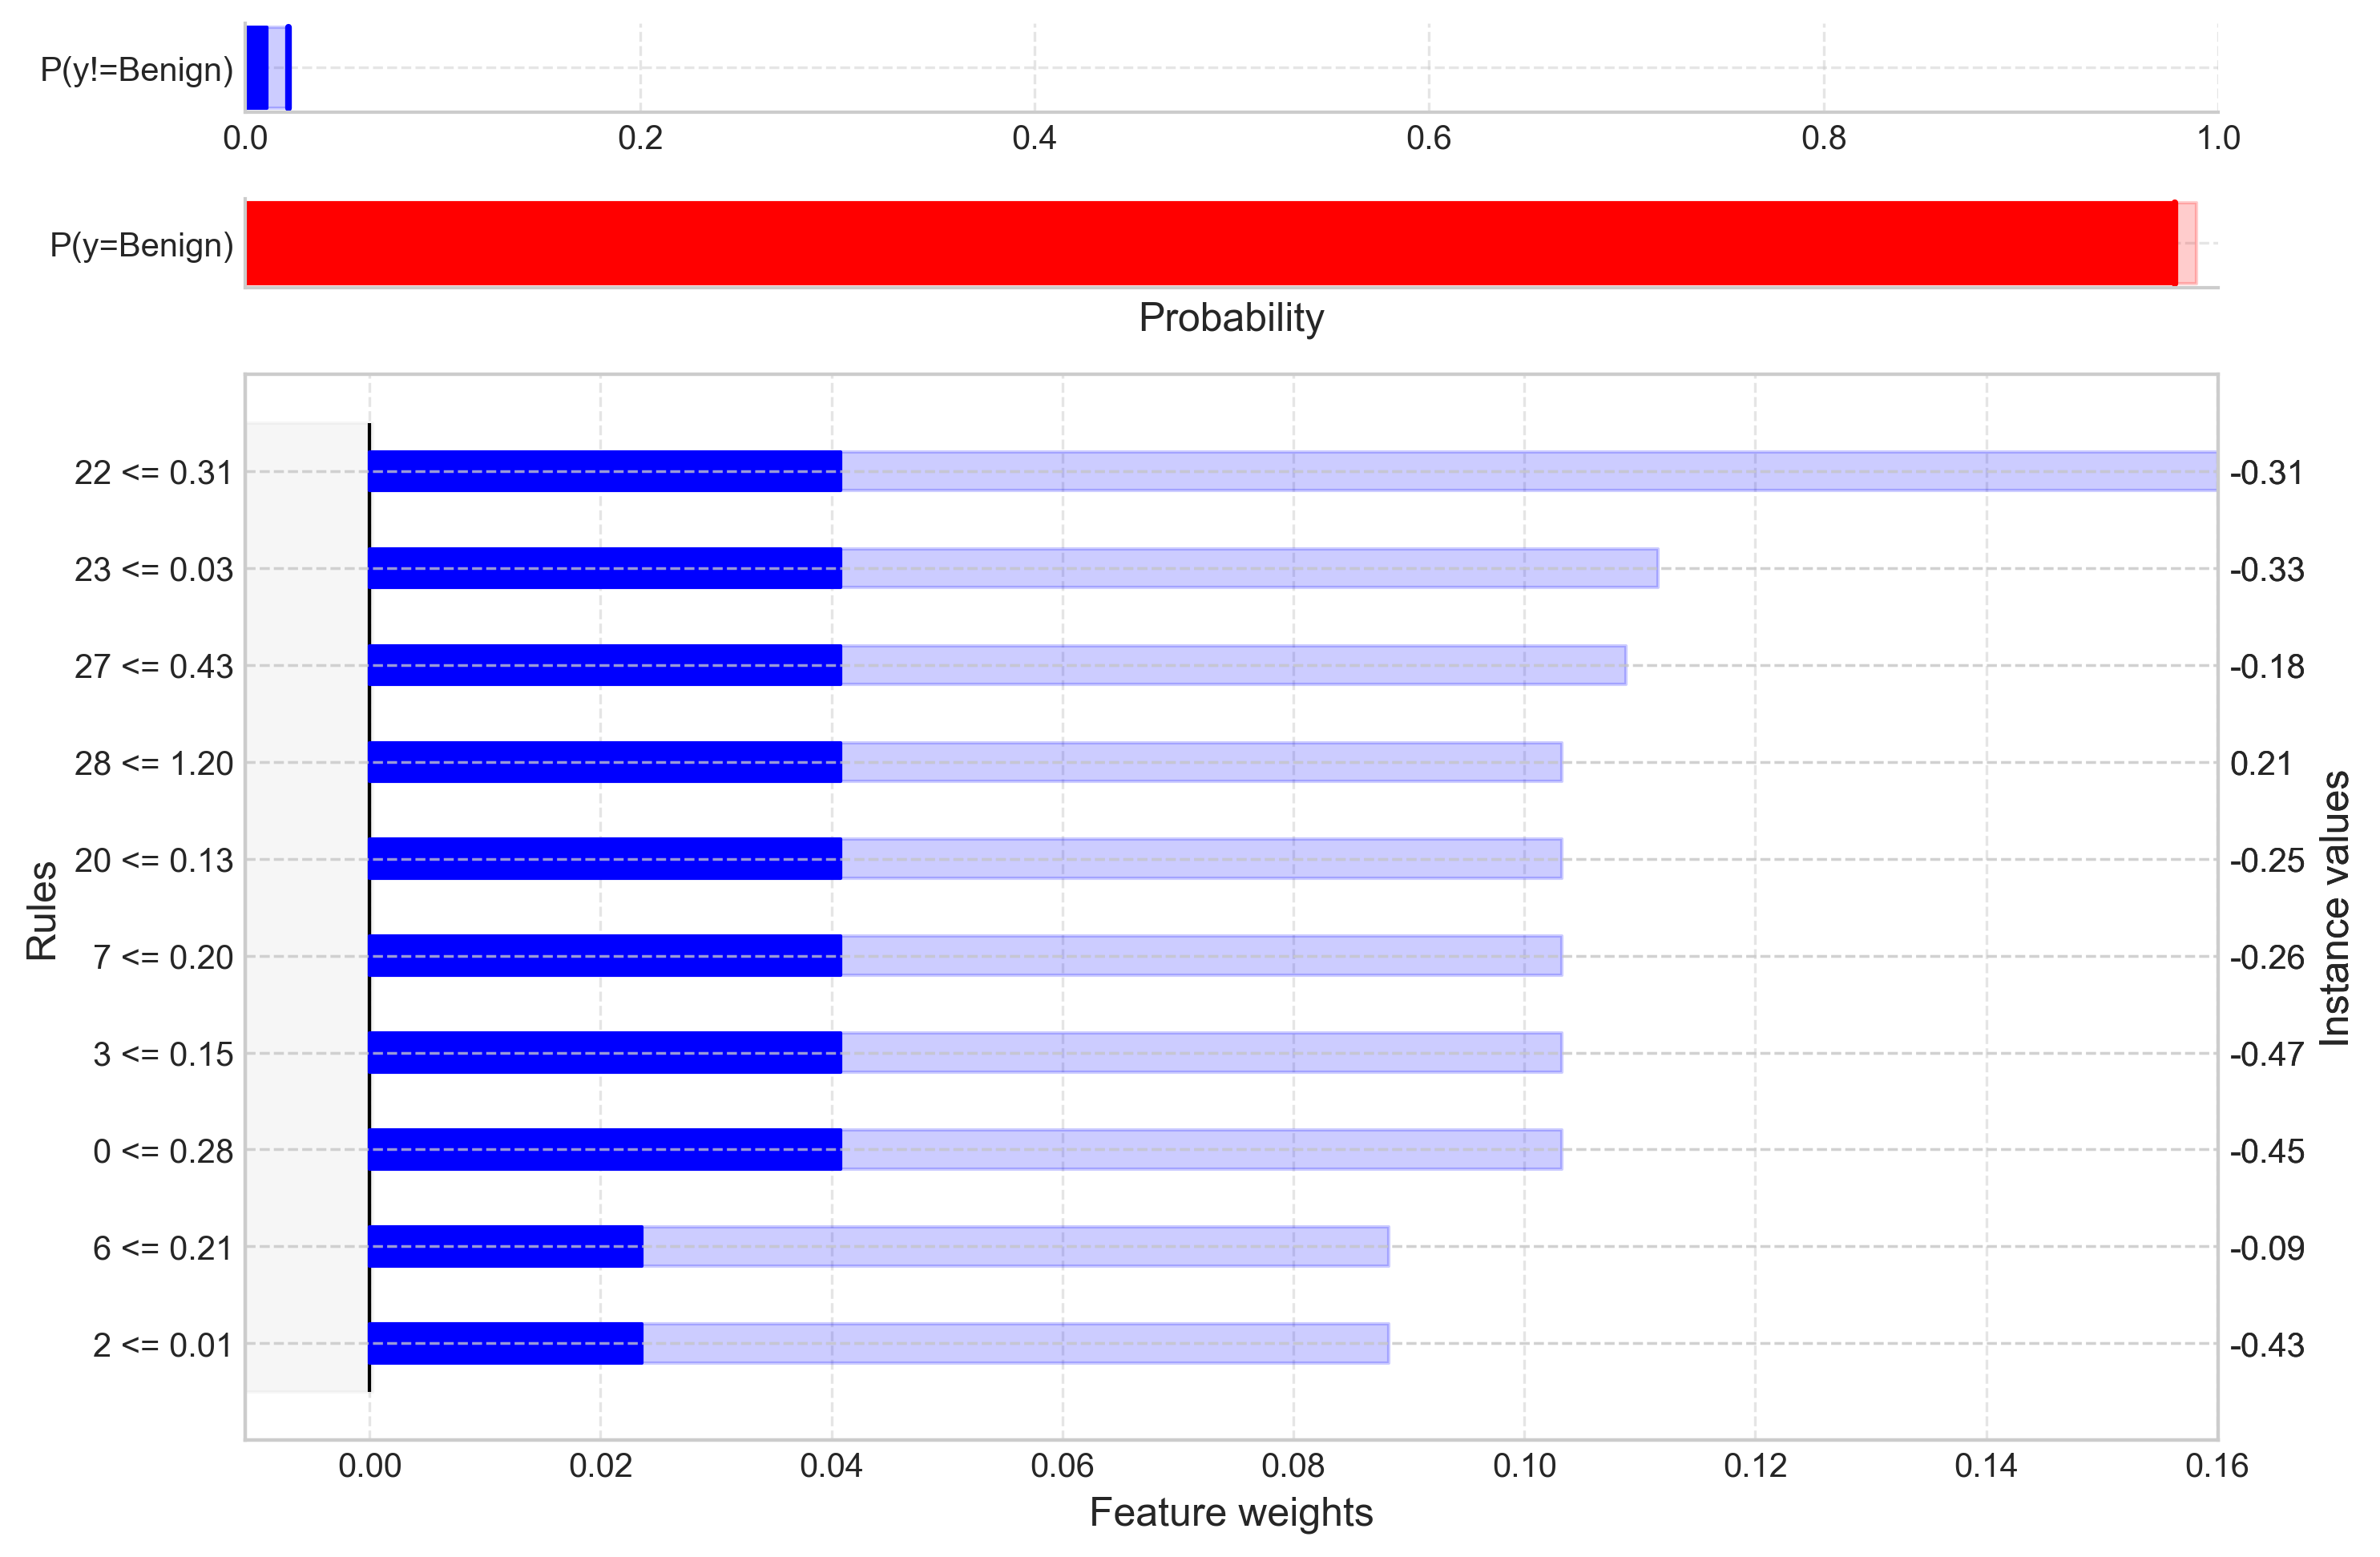

✓ Plotted first explanation using explainer's plot_style='plot_spec.default'


In [5]:
# Plot using the explainer's configured plot style
# This will use plot_spec.default since we set plot_style in the explainer
explanations_a.plot(index=0, show=True, uncertainty=True)
print("✓ Plotted first explanation using explainer's plot_style='plot_spec.default'")

## Method B: Wire plot plugin via explanation.plot() parameter

This allows dynamic plot style selection after explanations are generated,
enabling side-by-side comparison of different visualization styles.

In [6]:
# Create a second explainer without explicit plot_style (will default to fallback chain)
explainer_b = CalibratedExplainer(
    model,
    X_cal,
    y_cal,
    mode="classification",
    class_labels=["Malignant", "Benign"],
    # No plot_style parameter; will use defaults
)

explanations_b = explainer_b.explain_factual(X_test[:5])
print("✓ Created second explainer without explicit plot_style")
print(f"  Internal plot style chain: {explainer_b._plot_style_chain}")

✓ Created second explainer without explicit plot_style
  Internal plot style chain: ('plot_spec.default', 'legacy')


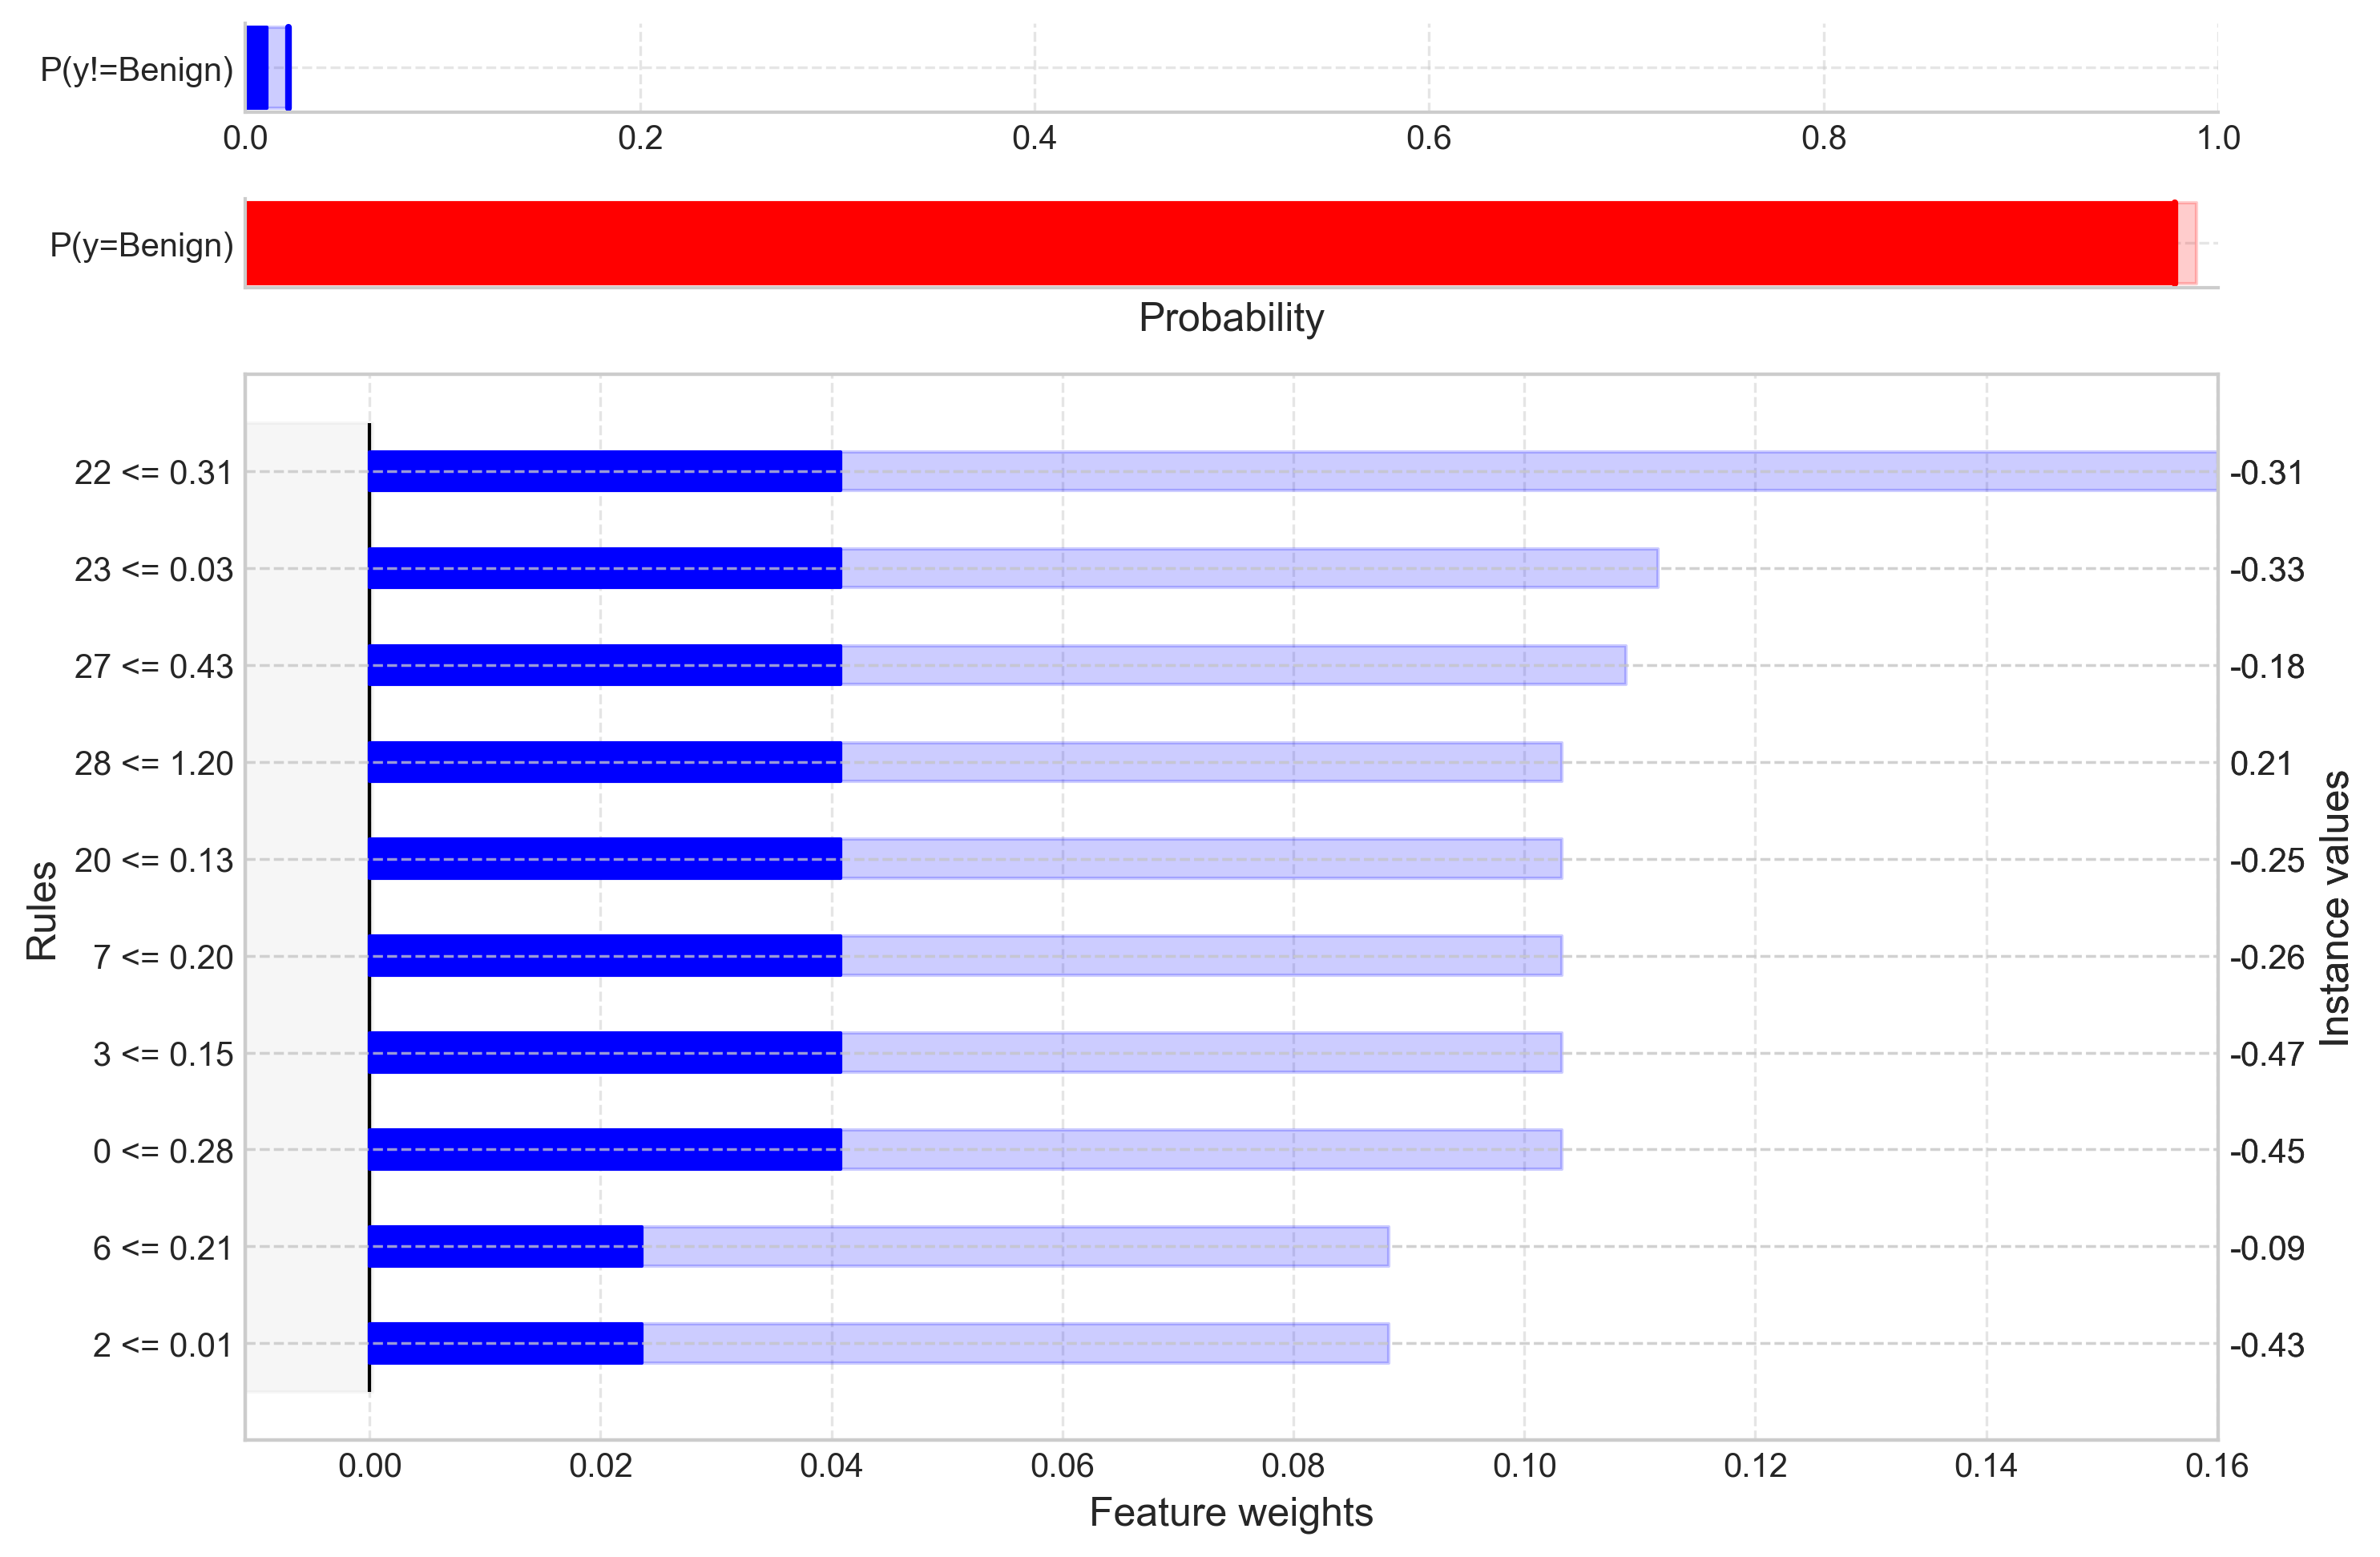

✓ Plotted with style_override='plot_spec.default' (Method B)


In [7]:
# ✓ Method B: Override plot style at plot time
# Plot same explanations with different style
explanations_b.plot(
    index=0,
    show=True,
    uncertainty=True,
    style_override="plot_spec.default",  # ← Dynamic style selection
)
print("✓ Plotted with style_override='plot_spec.default' (Method B)")

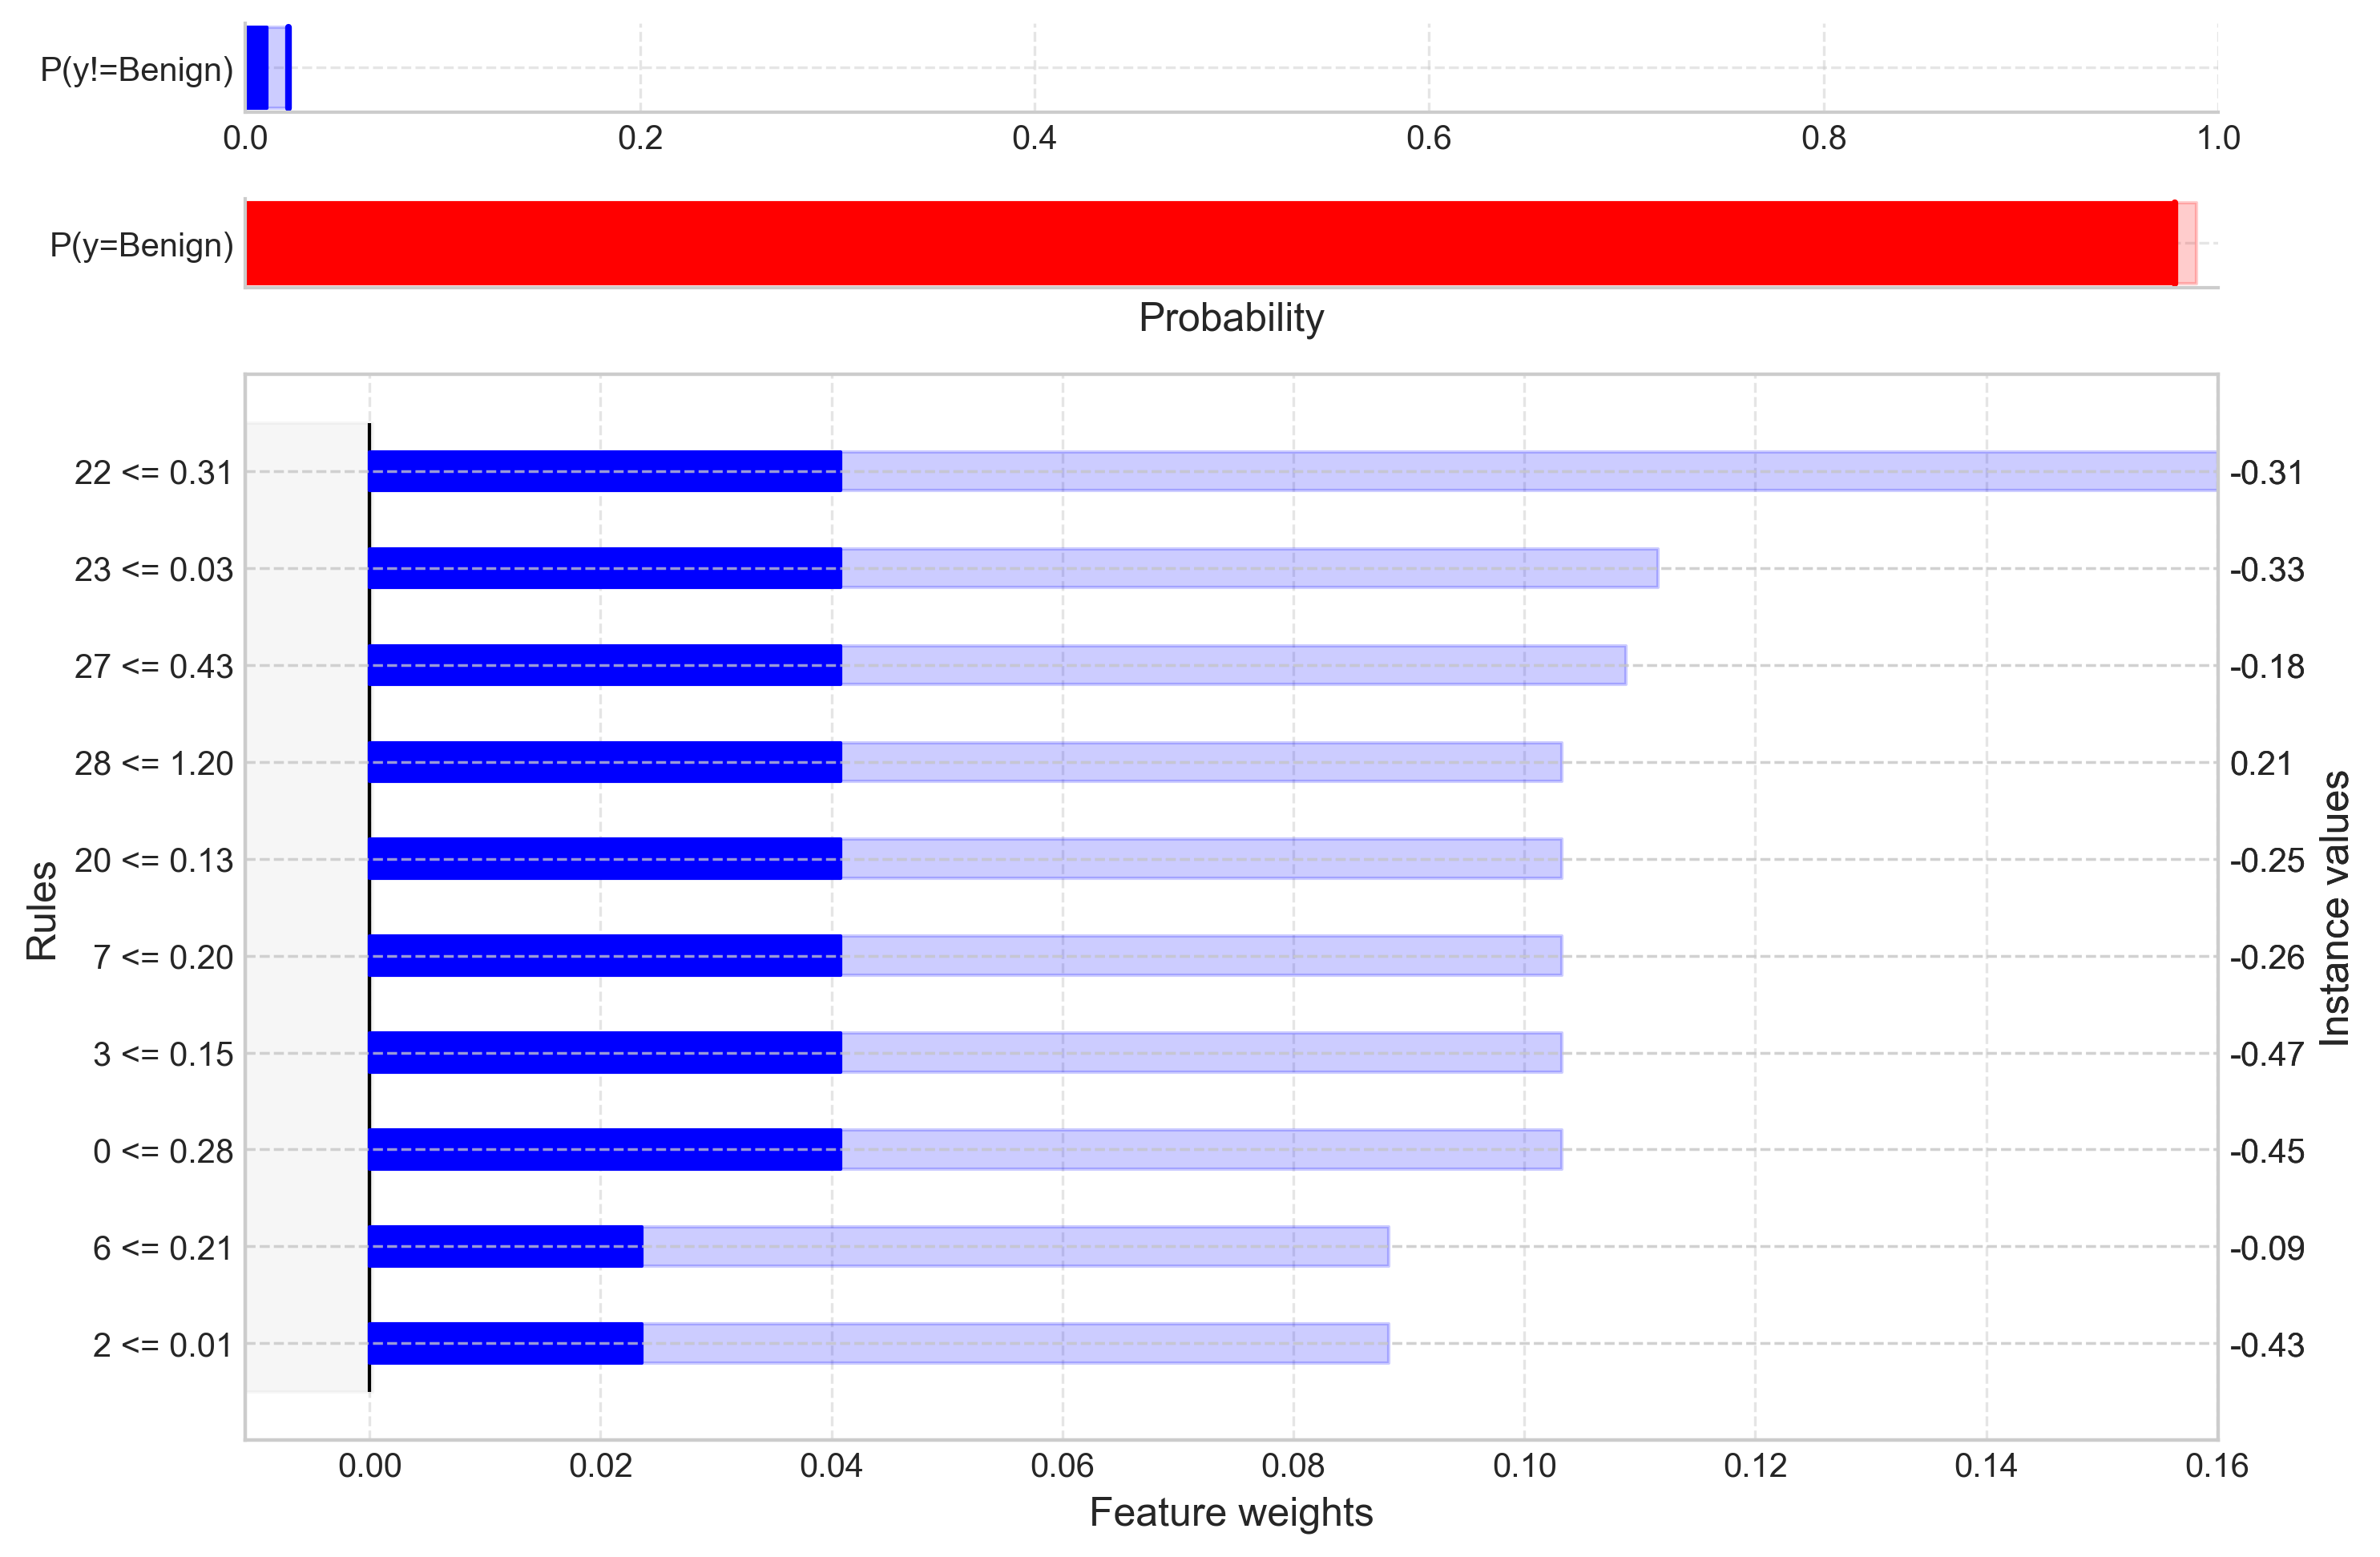

✓ Plotted same explanations with style_override='legacy' for comparison


In [8]:
# Plot same explanations with legacy style for comparison
explanations_b.plot(
    index=0,
    show=True,
    uncertainty=True,
    style_override="legacy",  # ← Different style, same explanations
)
print("✓ Plotted same explanations with style_override='legacy' for comparison")

## Method C: Wire plugins via environment variables

Environment variables enable runtime configuration without code changes,
making them ideal for CI/CD and operational deployment.

In [9]:
# ✓ Method C: Configure via environment variables
# Set environment before creating explainer
os.environ["CE_PLOT_STYLE"] = "plot_spec.default"
os.environ["CE_PLOT_STYLE_FALLBACKS"] = "legacy"

print("✓ Set environment variables:")
print(f"  CE_PLOT_STYLE = {os.environ.get('CE_PLOT_STYLE')}")
print(f"  CE_PLOT_STYLE_FALLBACKS = {os.environ.get('CE_PLOT_STYLE_FALLBACKS')}")

✓ Set environment variables:
  CE_PLOT_STYLE = plot_spec.default
  CE_PLOT_STYLE_FALLBACKS = legacy


In [10]:
# Create new explainer - it will pick up environment configuration
explainer_c = CalibratedExplainer(
    model,
    X_cal,
    y_cal,
    mode="classification",
    class_labels=["Malignant", "Benign"],
    # No explicit plot_style; uses environment variable
)

print("✓ Explainer created with environment-based configuration")
print(f"  Internal plot style chain (includes env vars): {explainer_c._plot_style_chain}")

✓ Explainer created with environment-based configuration
  Internal plot style chain (includes env vars): ('plot_spec.default', 'legacy')


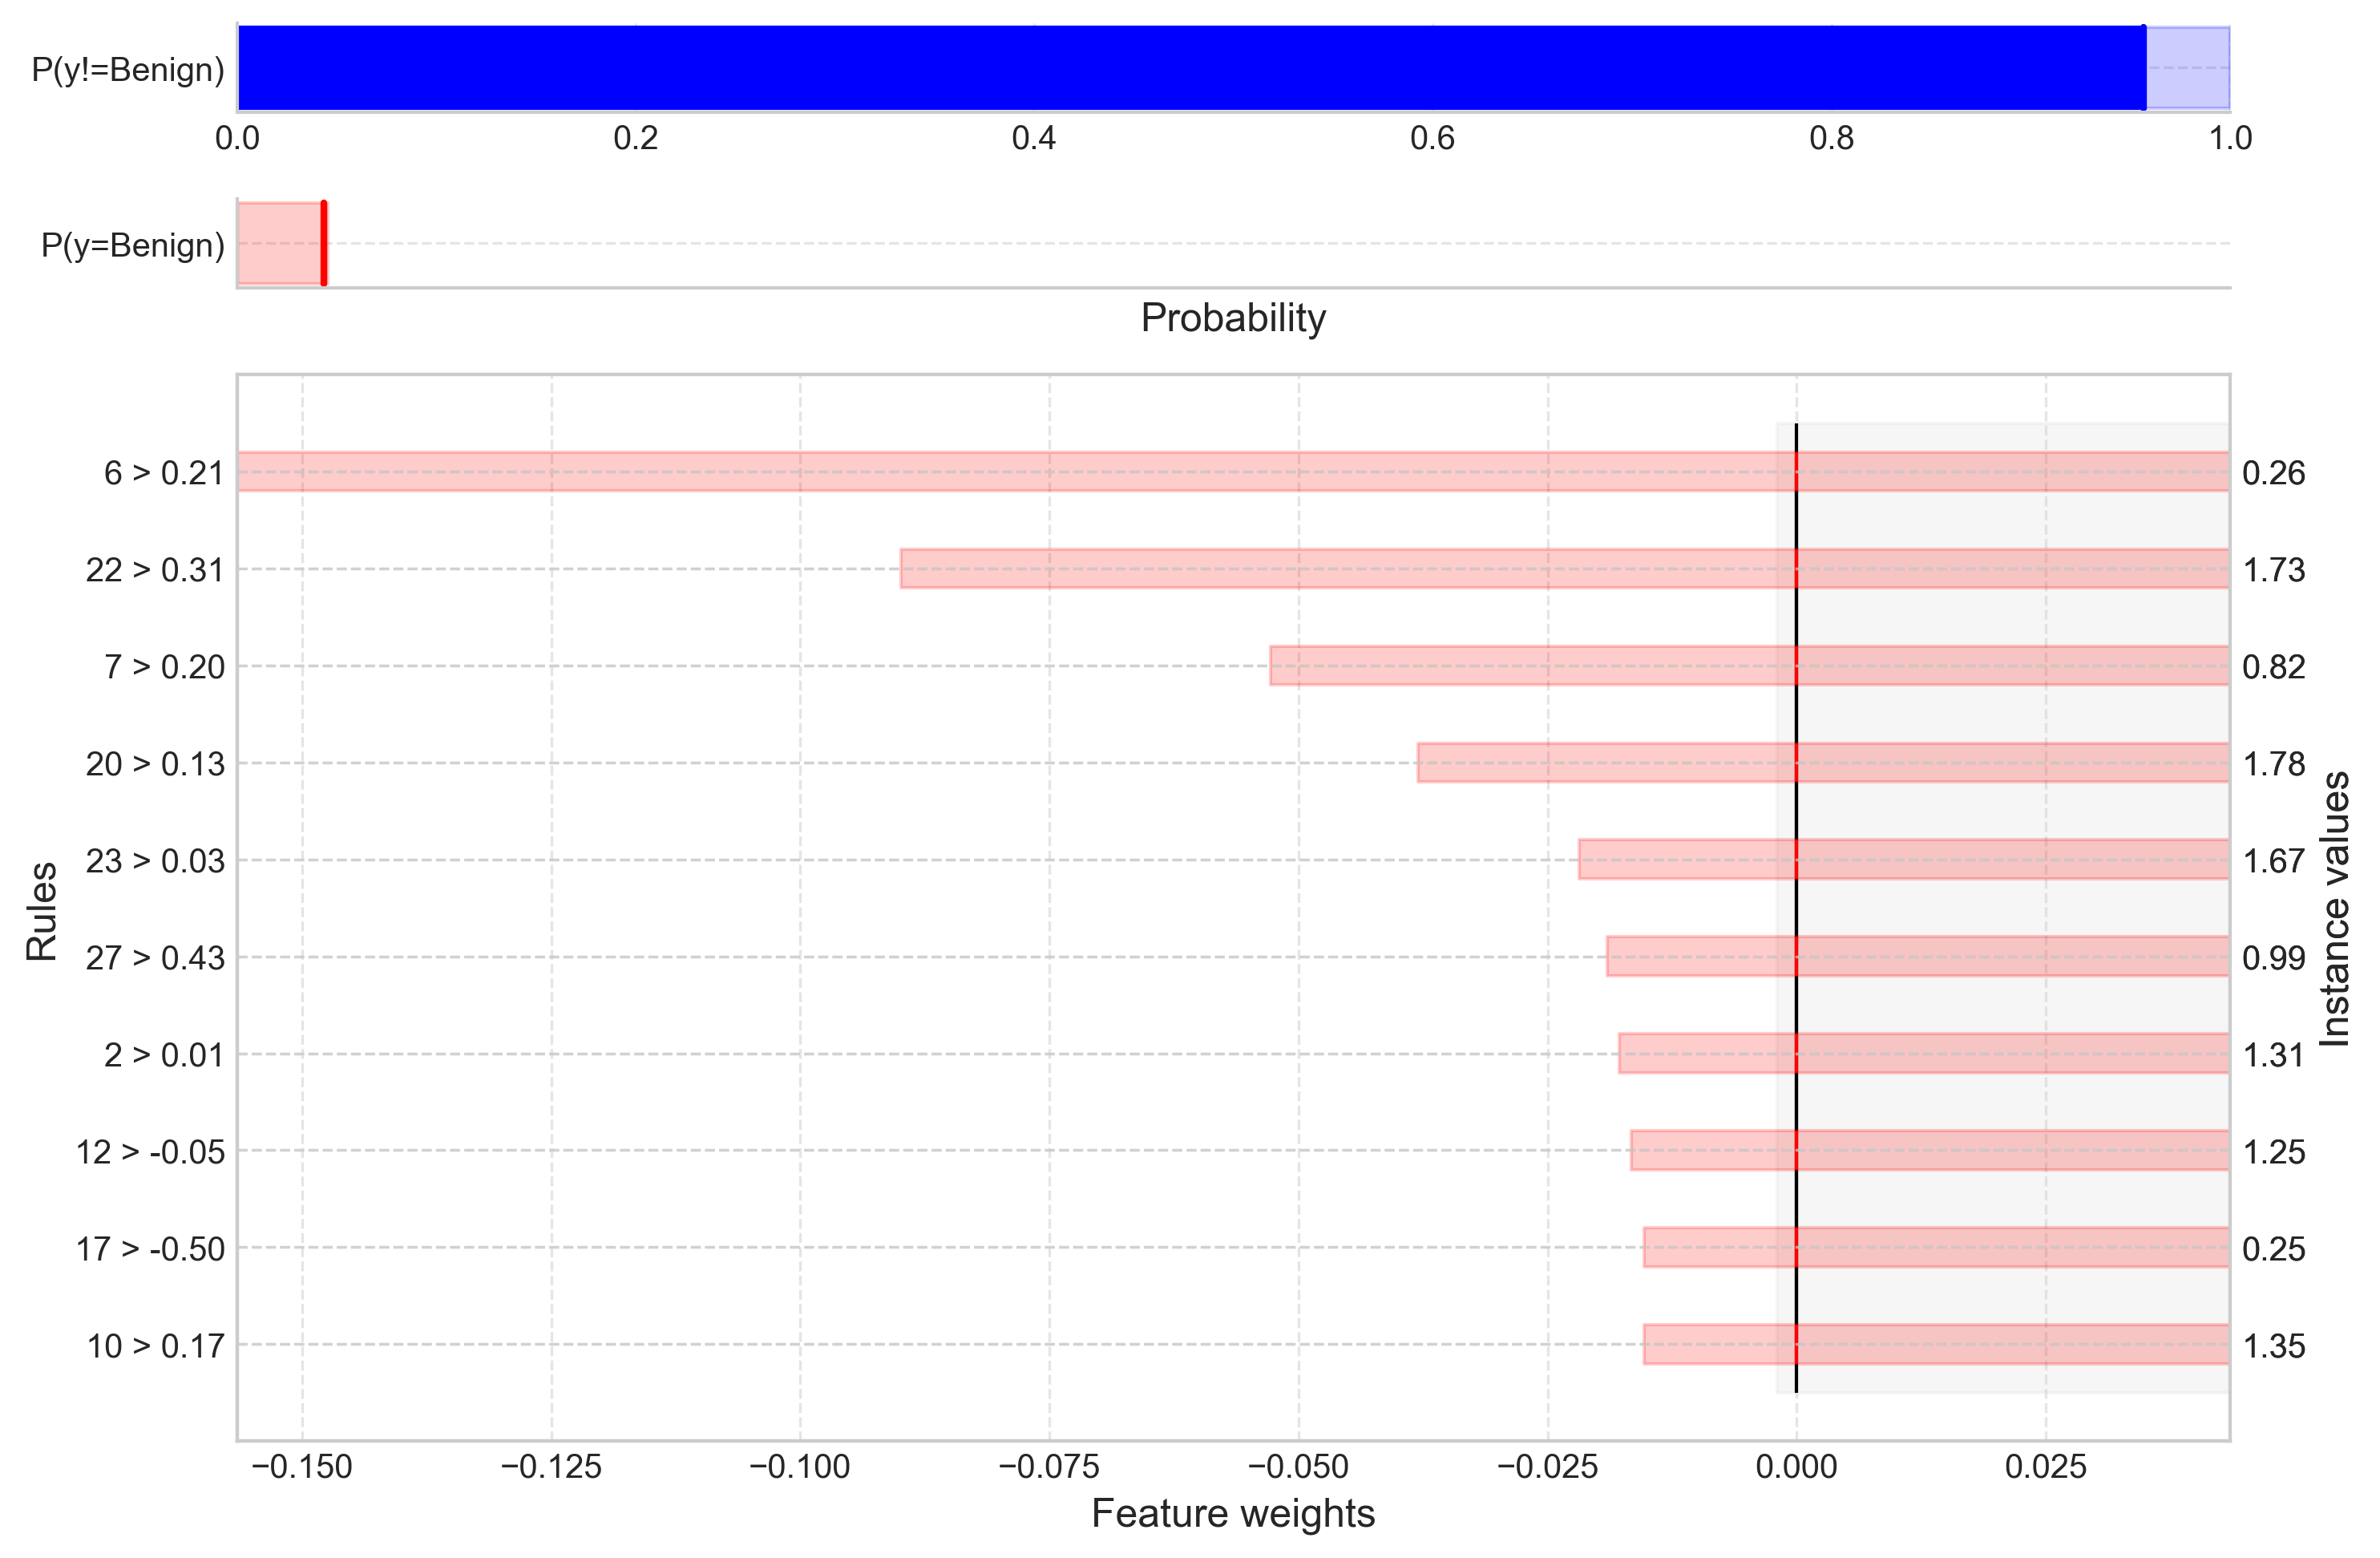

✓ Plotted using environment-configured style (Method C)


In [11]:
# Generate and plot with environment-configured style
explanations_c = explainer_c.explain_factual(X_test[:5])

explanations_c.plot(index=1, show=True, uncertainty=True)
print("✓ Plotted using environment-configured style (Method C)")

## Method E: Plugin dependency propagation via plugin metadata

Explanation plugins can declare their preferred plot and interval plugins
through metadata. This enables automatic dependency seeding without explicit user configuration.

In [12]:
# Example: Create a custom explanation plugin with declared dependencies
from calibrated_explanations.plugins.builtins import LegacyFactualExplanationPlugin


class HelloFactualPlugin(LegacyFactualExplanationPlugin):
    """Example explanation plugin with explicit plot and interval dependencies."""

    plugin_meta = {
        **LegacyFactualExplanationPlugin.plugin_meta,
        "name": "hello.explanation.factual",
        # ↓ Declare preferred dependencies
        "plot_dependency": "plot_spec.default",  # Prefer PlotSpec plots
        "interval_dependency": "core.interval.legacy",  # Prefer legacy intervals
        "dependencies": ("plot_spec.default", "core.interval.legacy"),
        "trusted": False,
    }


print("✓ Created custom explanation plugin with declared dependencies")
print(f"  plot_dependency: {HelloFactualPlugin.plugin_meta.get('plot_dependency')}")
print(f"  interval_dependency: {HelloFactualPlugin.plugin_meta.get('interval_dependency')}")

✓ Created custom explanation plugin with declared dependencies
  plot_dependency: plot_spec.default
  interval_dependency: core.interval.legacy


In [13]:
# Register the plugin with its dependencies
from calibrated_explanations.plugins.registry import register_explanation_plugin

hello_plugin = HelloFactualPlugin()
register_explanation_plugin("hello.explanation.factual", hello_plugin)

print("✓ Registered custom plugin with dependencies")

✓ Registered custom plugin with dependencies


In [14]:
# Clear environment to isolate Method E configuration
os.environ.pop("CE_PLOT_STYLE", None)
os.environ.pop("CE_PLOT_STYLE_FALLBACKS", None)

# Create explainer with the plugin that declares dependencies
# It will automatically use dependencies from plugin metadata
explainer_e = CalibratedExplainer(
    model,
    X_cal,
    y_cal,
    mode="classification",
    class_labels=["Malignant", "Benign"],
    factual_plugin="hello.explanation.factual",  # Use plugin with dependencies
    # plot_style not specified; will be seeded from plugin metadata
)

print("✓ Explainer created with plugin declaring dependencies")
print(f"  Plot style chain (includes plugin dependencies): {explainer_e._plot_style_chain}")
print("  Note: plot_spec.default is first (from plugin's plot_dependency)")

✓ Explainer created with plugin declaring dependencies
  Plot style chain (includes plugin dependencies): ('plot_spec.default', 'legacy')
  Note: plot_spec.default is first (from plugin's plot_dependency)


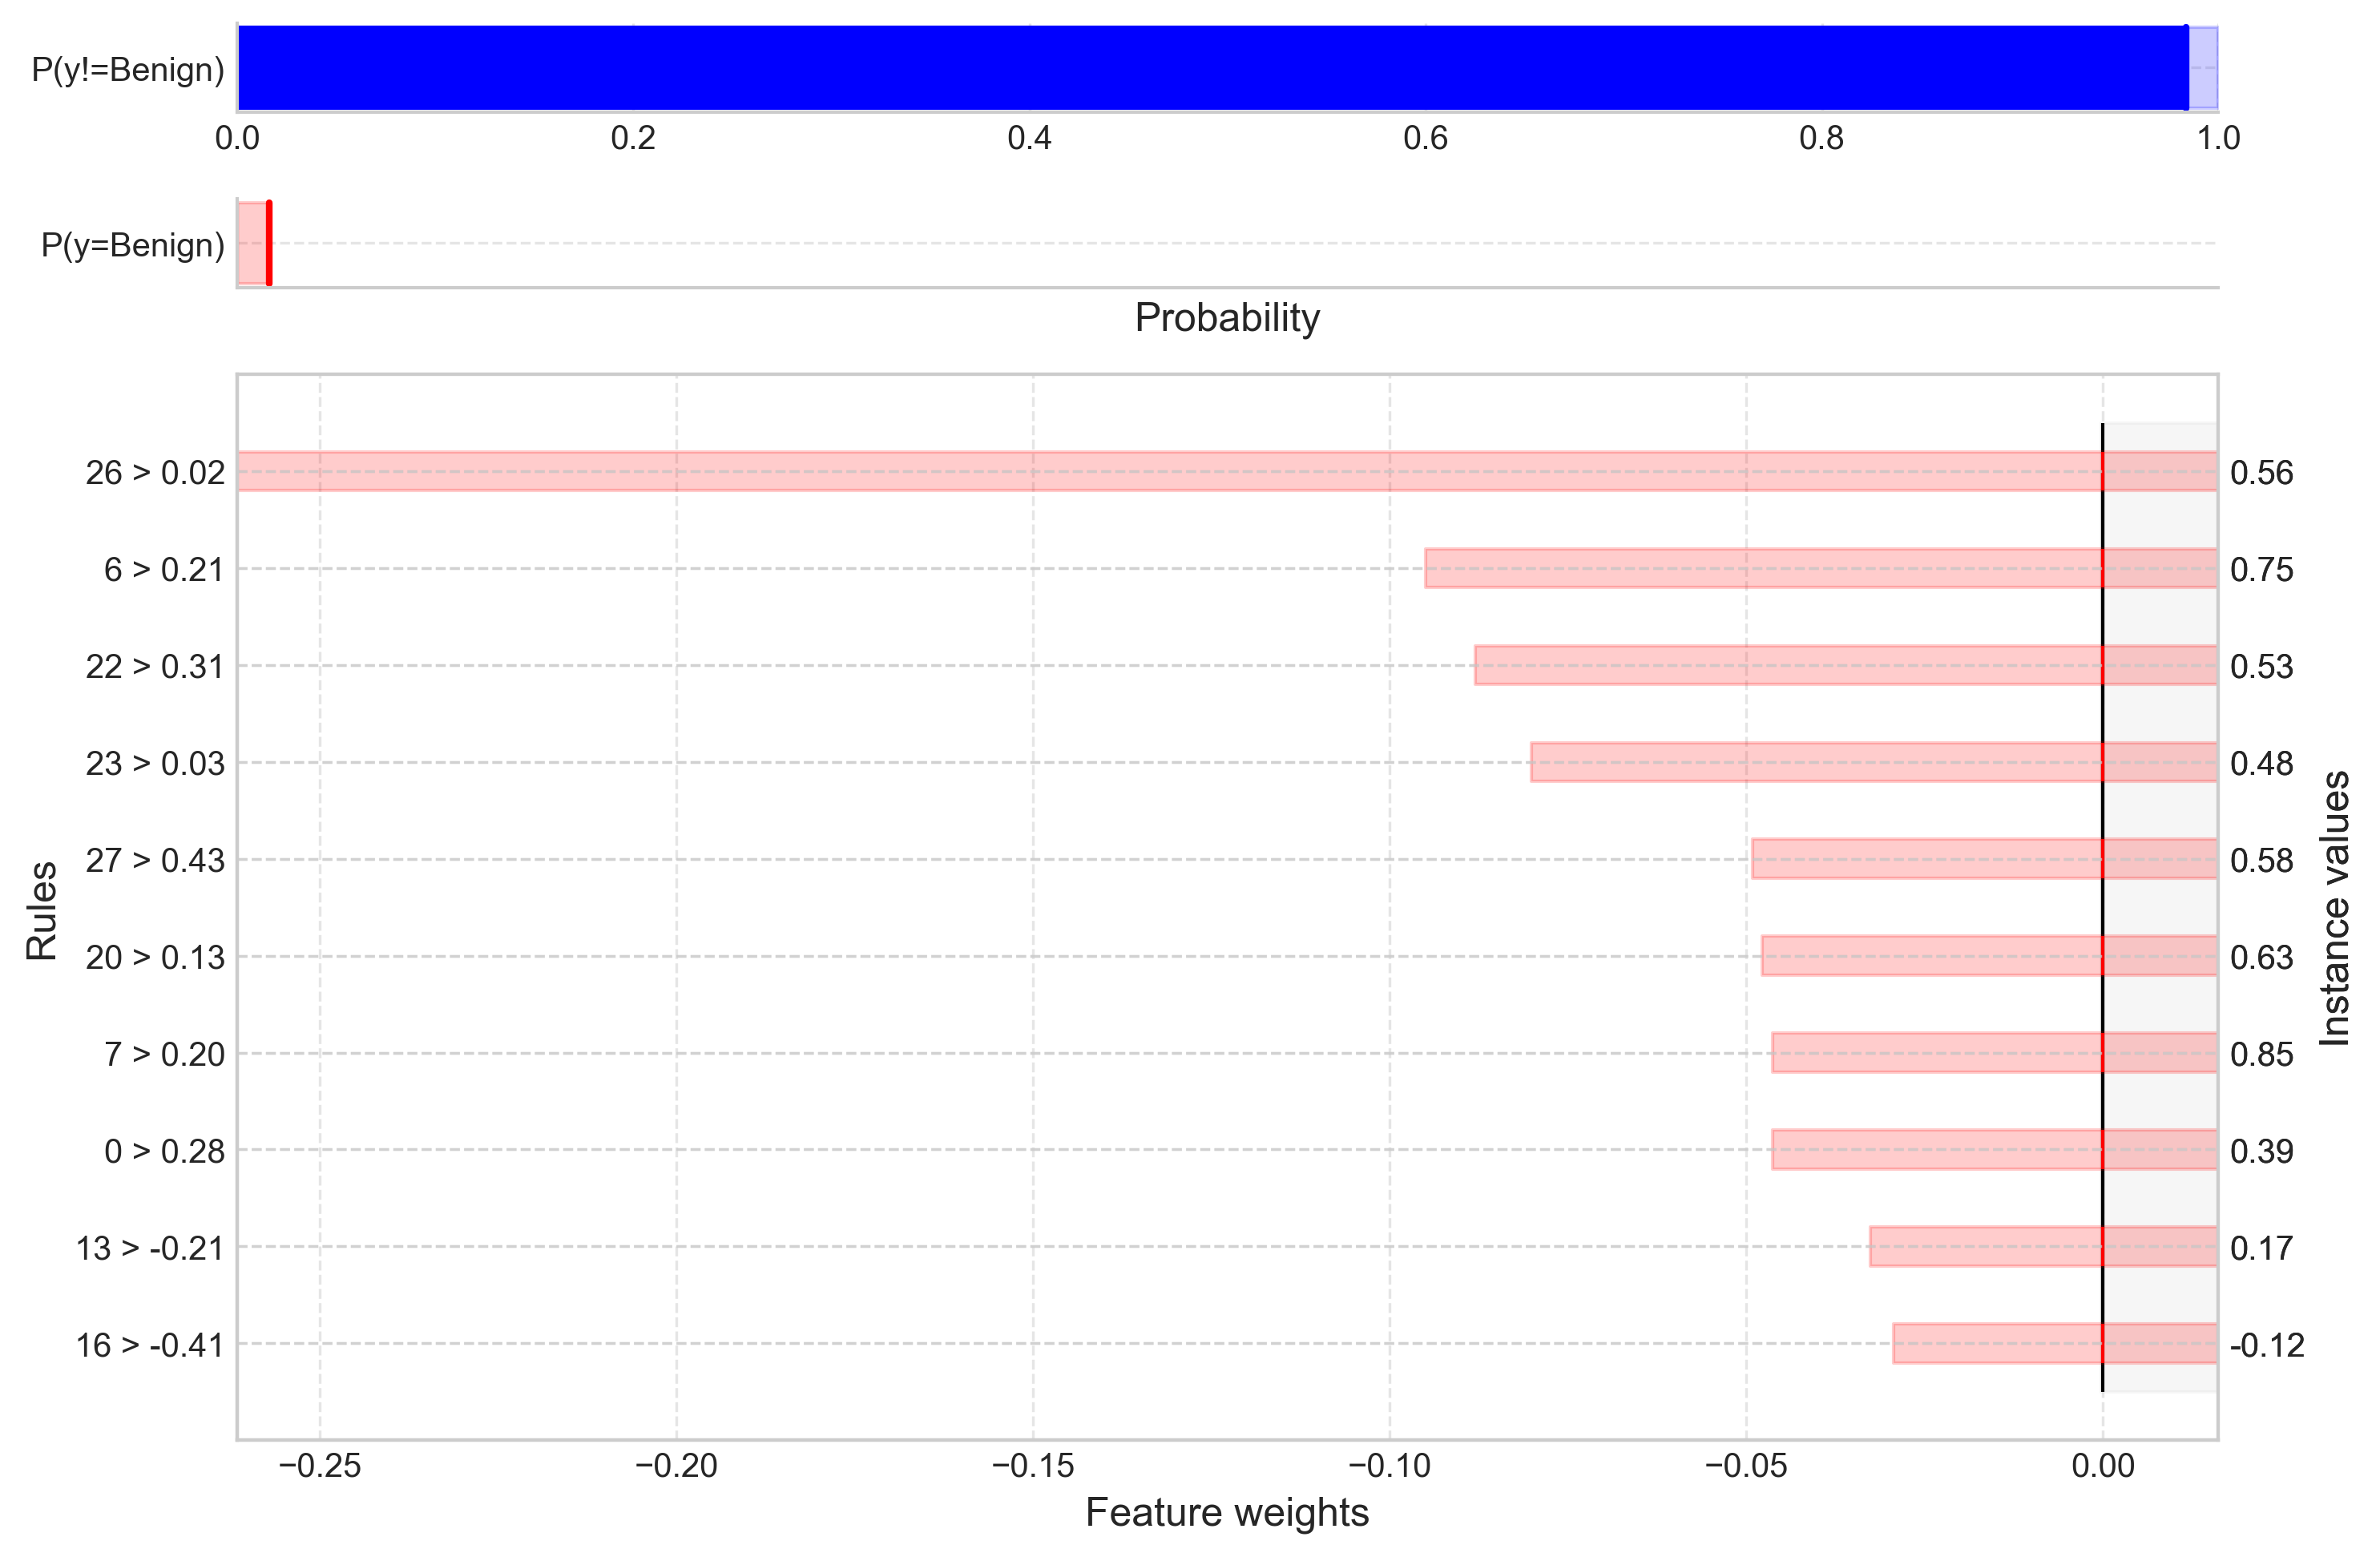

✓ Plotted using plot style from plugin metadata dependencies (Method E)


In [15]:
# Generate and plot using plugin-declared dependencies
explanations_e = explainer_e.explain_factual(X_test[:5])

explanations_e.plot(index=2, show=True, uncertainty=True)
print("✓ Plotted using plot style from plugin metadata dependencies (Method E)")

## Priority and Fallback Chain Resolution

When multiple configuration methods are active, the system applies this priority order:

1. **Explicit parameters** (Method A & B) – Highest priority
2. **Environment variables** (Method C)
3. **pyproject.toml** (Method D)
4. **Plugin metadata dependencies** (Method E)
5. **Built-in defaults** – "plot_spec.default" → "legacy" – Lowest priority

If a plugin fails or is unavailable, the system walks the fallback chain automatically.

In [16]:
# Demonstrate priority with multiple active configurations
os.environ["CE_PLOT_STYLE"] = "plot_spec.default"

# Explicit parameter takes precedence over environment variable
explainer_priority = CalibratedExplainer(
    model,
    X_cal,
    y_cal,
    mode="classification",
    class_labels=["Malignant", "Benign"],
    plot_style="legacy",  # ← Explicit parameter (highest priority)
    # CE_PLOT_STYLE env var is also set to "plot_spec.default"
    # but the explicit parameter wins
)

print("Configuration priority demonstration:")
print("  Environment: CE_PLOT_STYLE='plot_spec.default'")
print("  Explicit parameter: plot_style='legacy'")
print(f"  Result: {explainer_priority._plot_style_chain[0]}")
print("  → Explicit parameter takes precedence!")

Configuration priority demonstration:
  Environment: CE_PLOT_STYLE='plot_spec.default'
  Explicit parameter: plot_style='legacy'
  Result: legacy
  → Explicit parameter takes precedence!


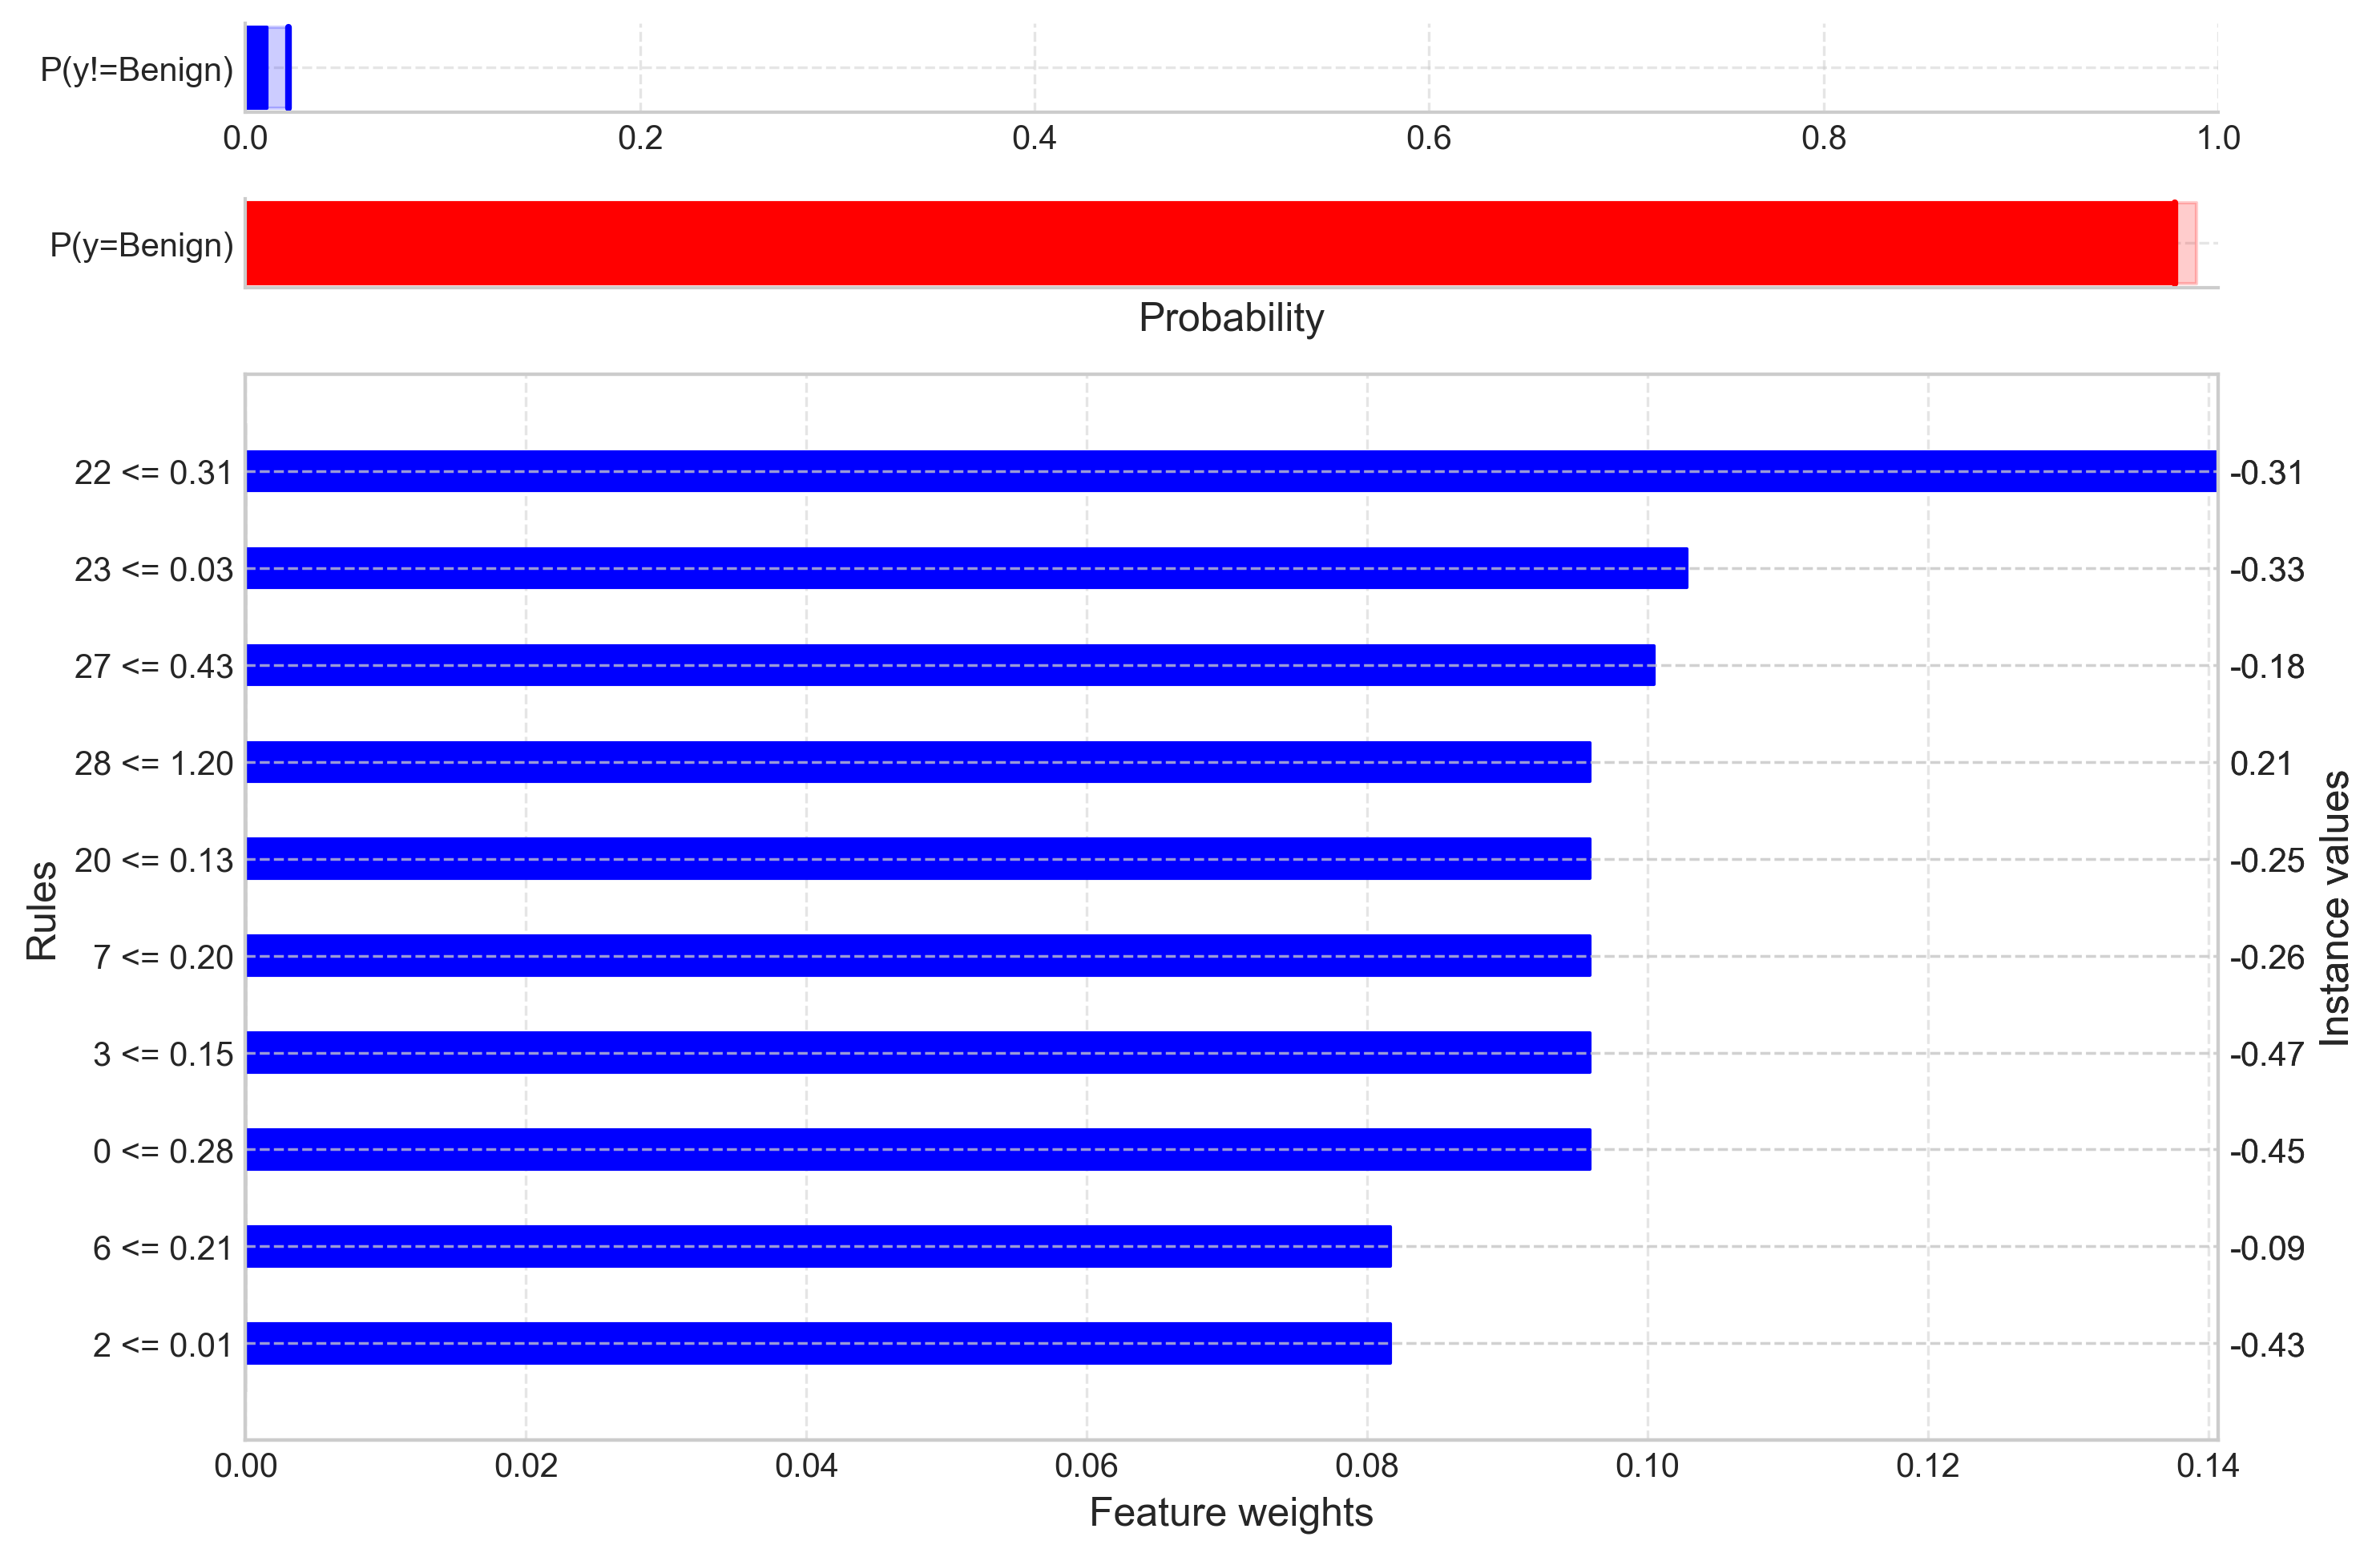

In [17]:
# Demonstrate fallback chain when primary plugin fails
explanations = explainer_priority.explain_factual(X_test[:3])

# Plot with unavailable plugin in chain
try:
    explanations.plot(
        index=0,
        show=True,
        style_override="nonexistent.plugin",  # Will fail, then try fallbacks
    )
except Exception:
    print("Note: nonexistent.plugin will fall back to next in chain")

## Comparing Built-in Plot Styles

The system includes two main plot styles:
- **legacy** – Original matplotlib-based plotting (always available as fallback)
- **plot_spec.default** – Modern PlotSpec-based visualization with better structure

In [18]:
# Create a single set of explanations
explainer_compare = CalibratedExplainer(
    model,
    X_cal,
    y_cal,
    mode="classification",
    class_labels=["Malignant", "Benign"],
)

explanations_compare = explainer_compare.explain_factual(X_test[:3])

print("Explanation object ready for style comparison")

Explanation object ready for style comparison



--- Using plot_spec.default style ---


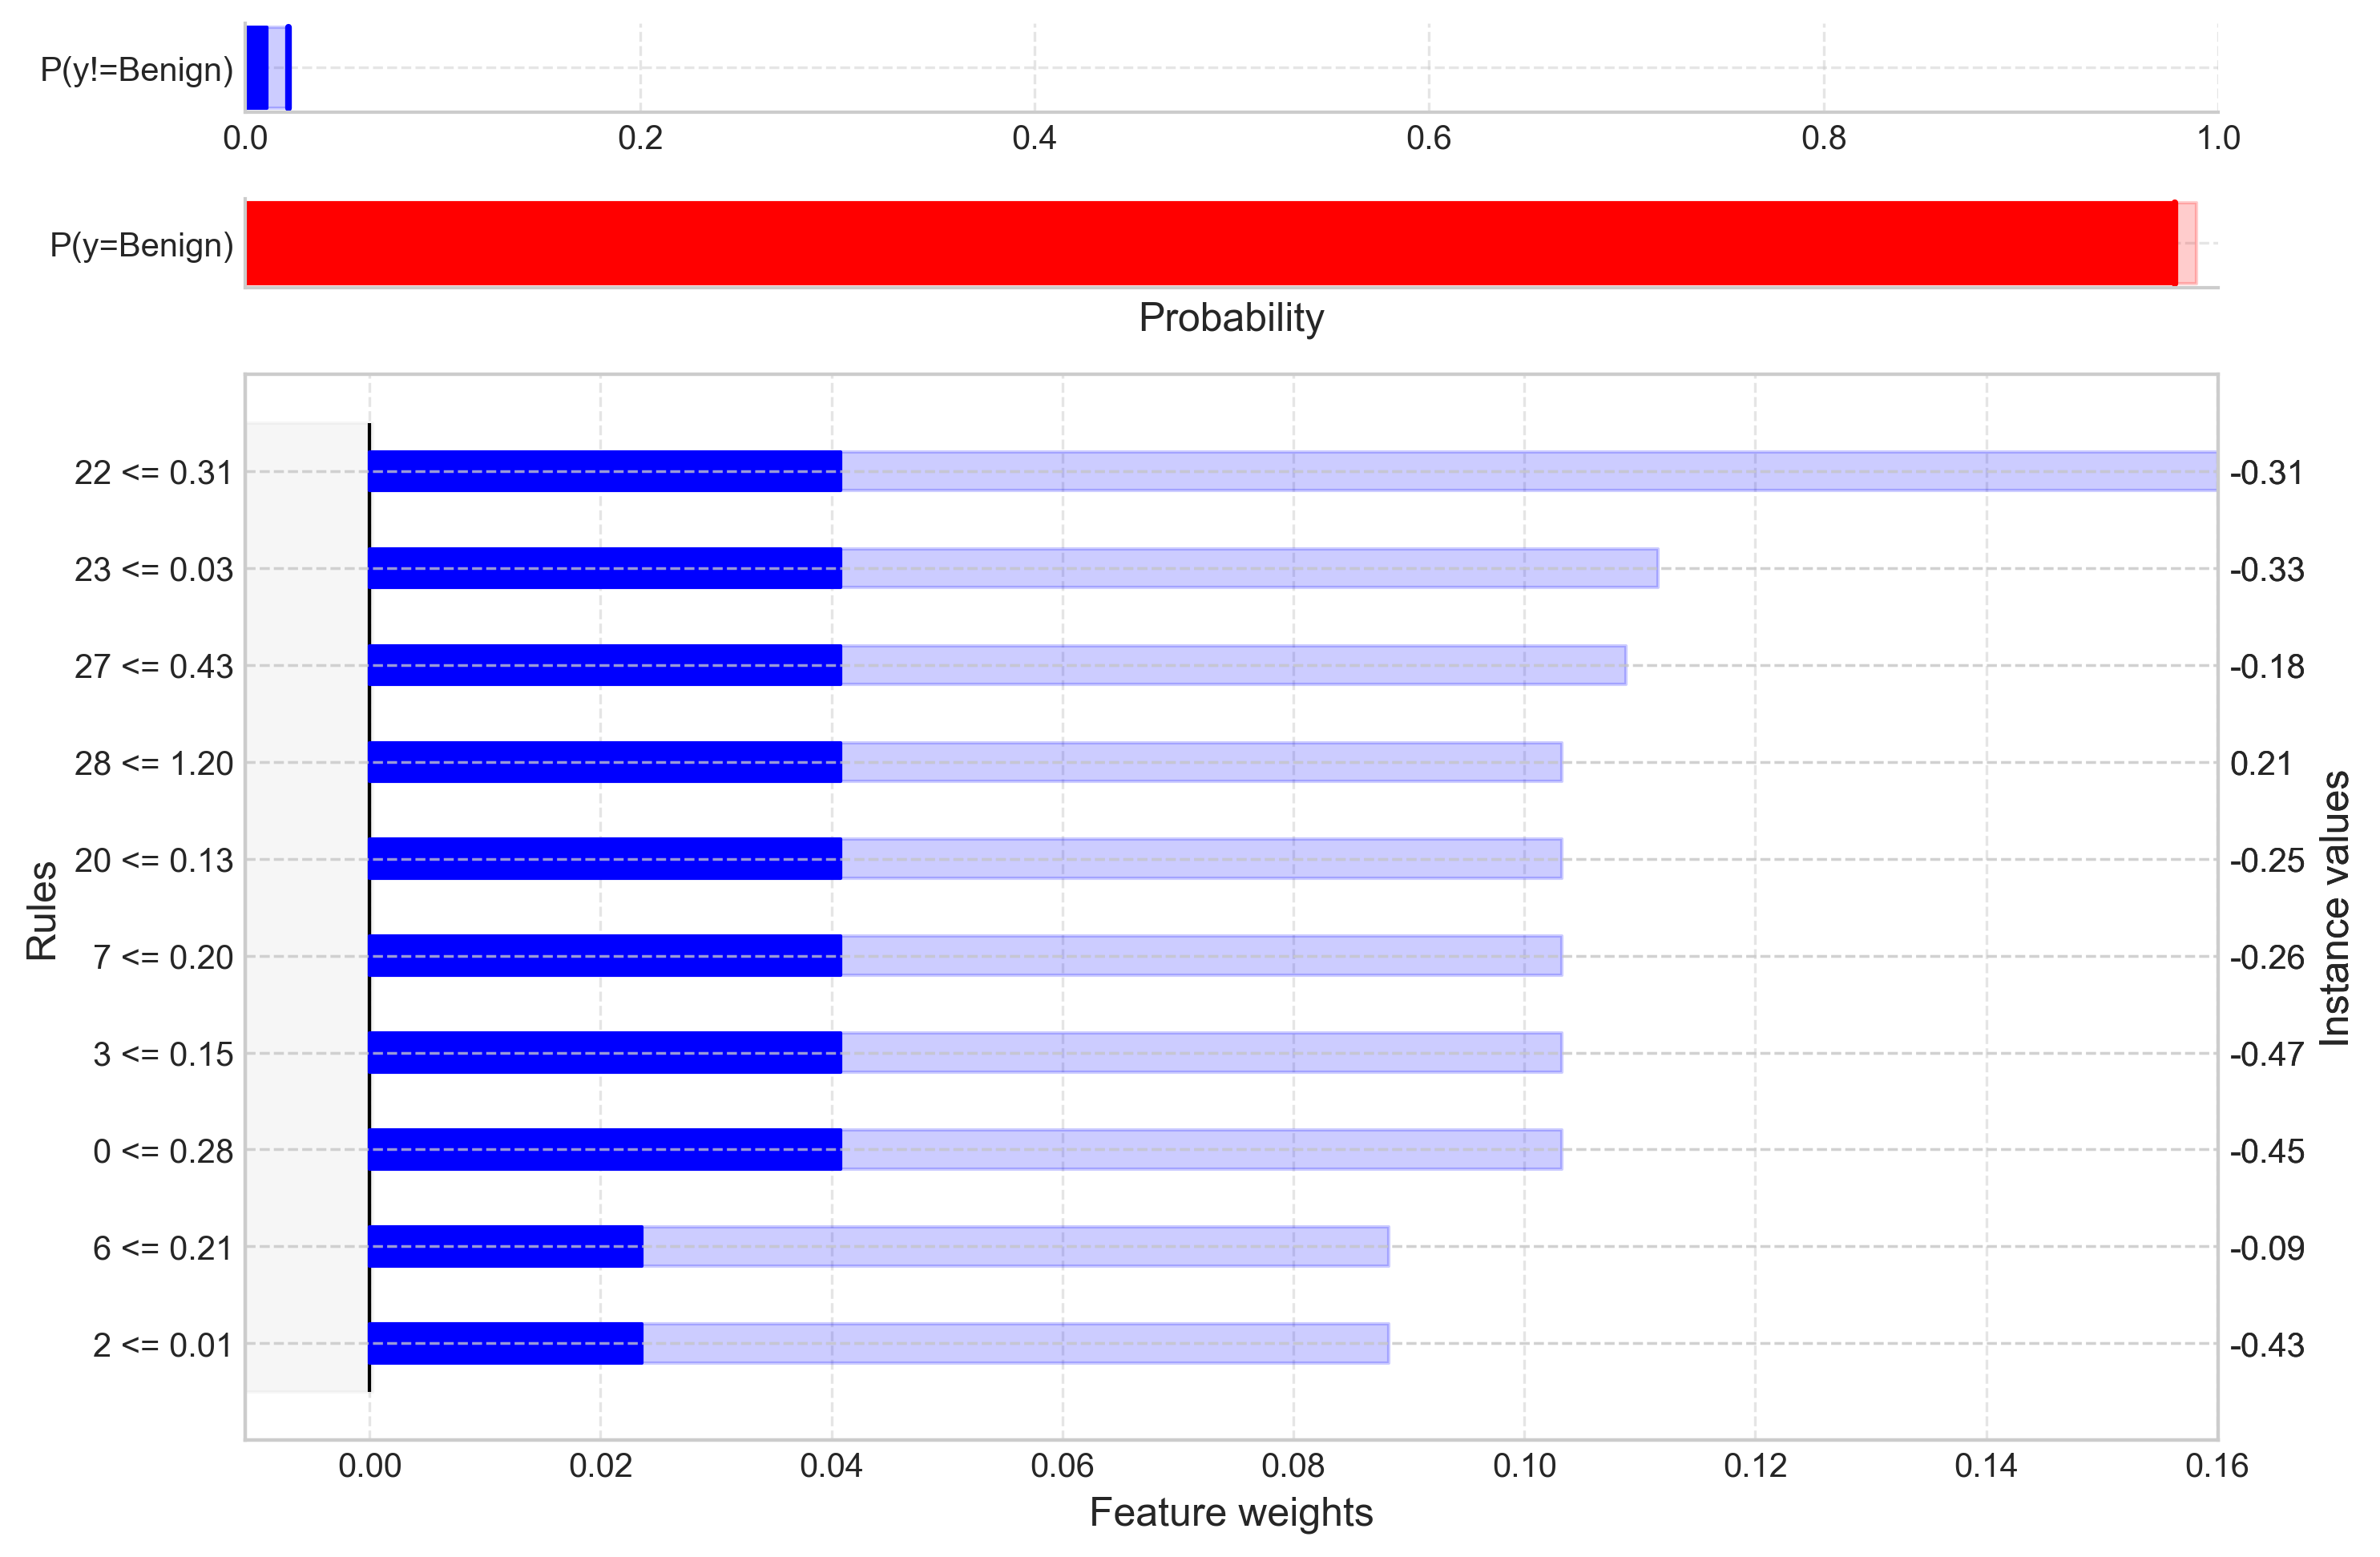

✓ PlotSpec-based visualization rendered


In [19]:
# Plot with PlotSpec style
print("\n--- Using plot_spec.default style ---")
explanations_compare.plot(
    index=0,
    show=True,
    style_override="plot_spec.default",
    uncertainty=True,
)
print("✓ PlotSpec-based visualization rendered")


--- Using legacy style ---


C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\legacy\plotting.py:204: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


✓ Legacy matplotlib-based visualization rendered


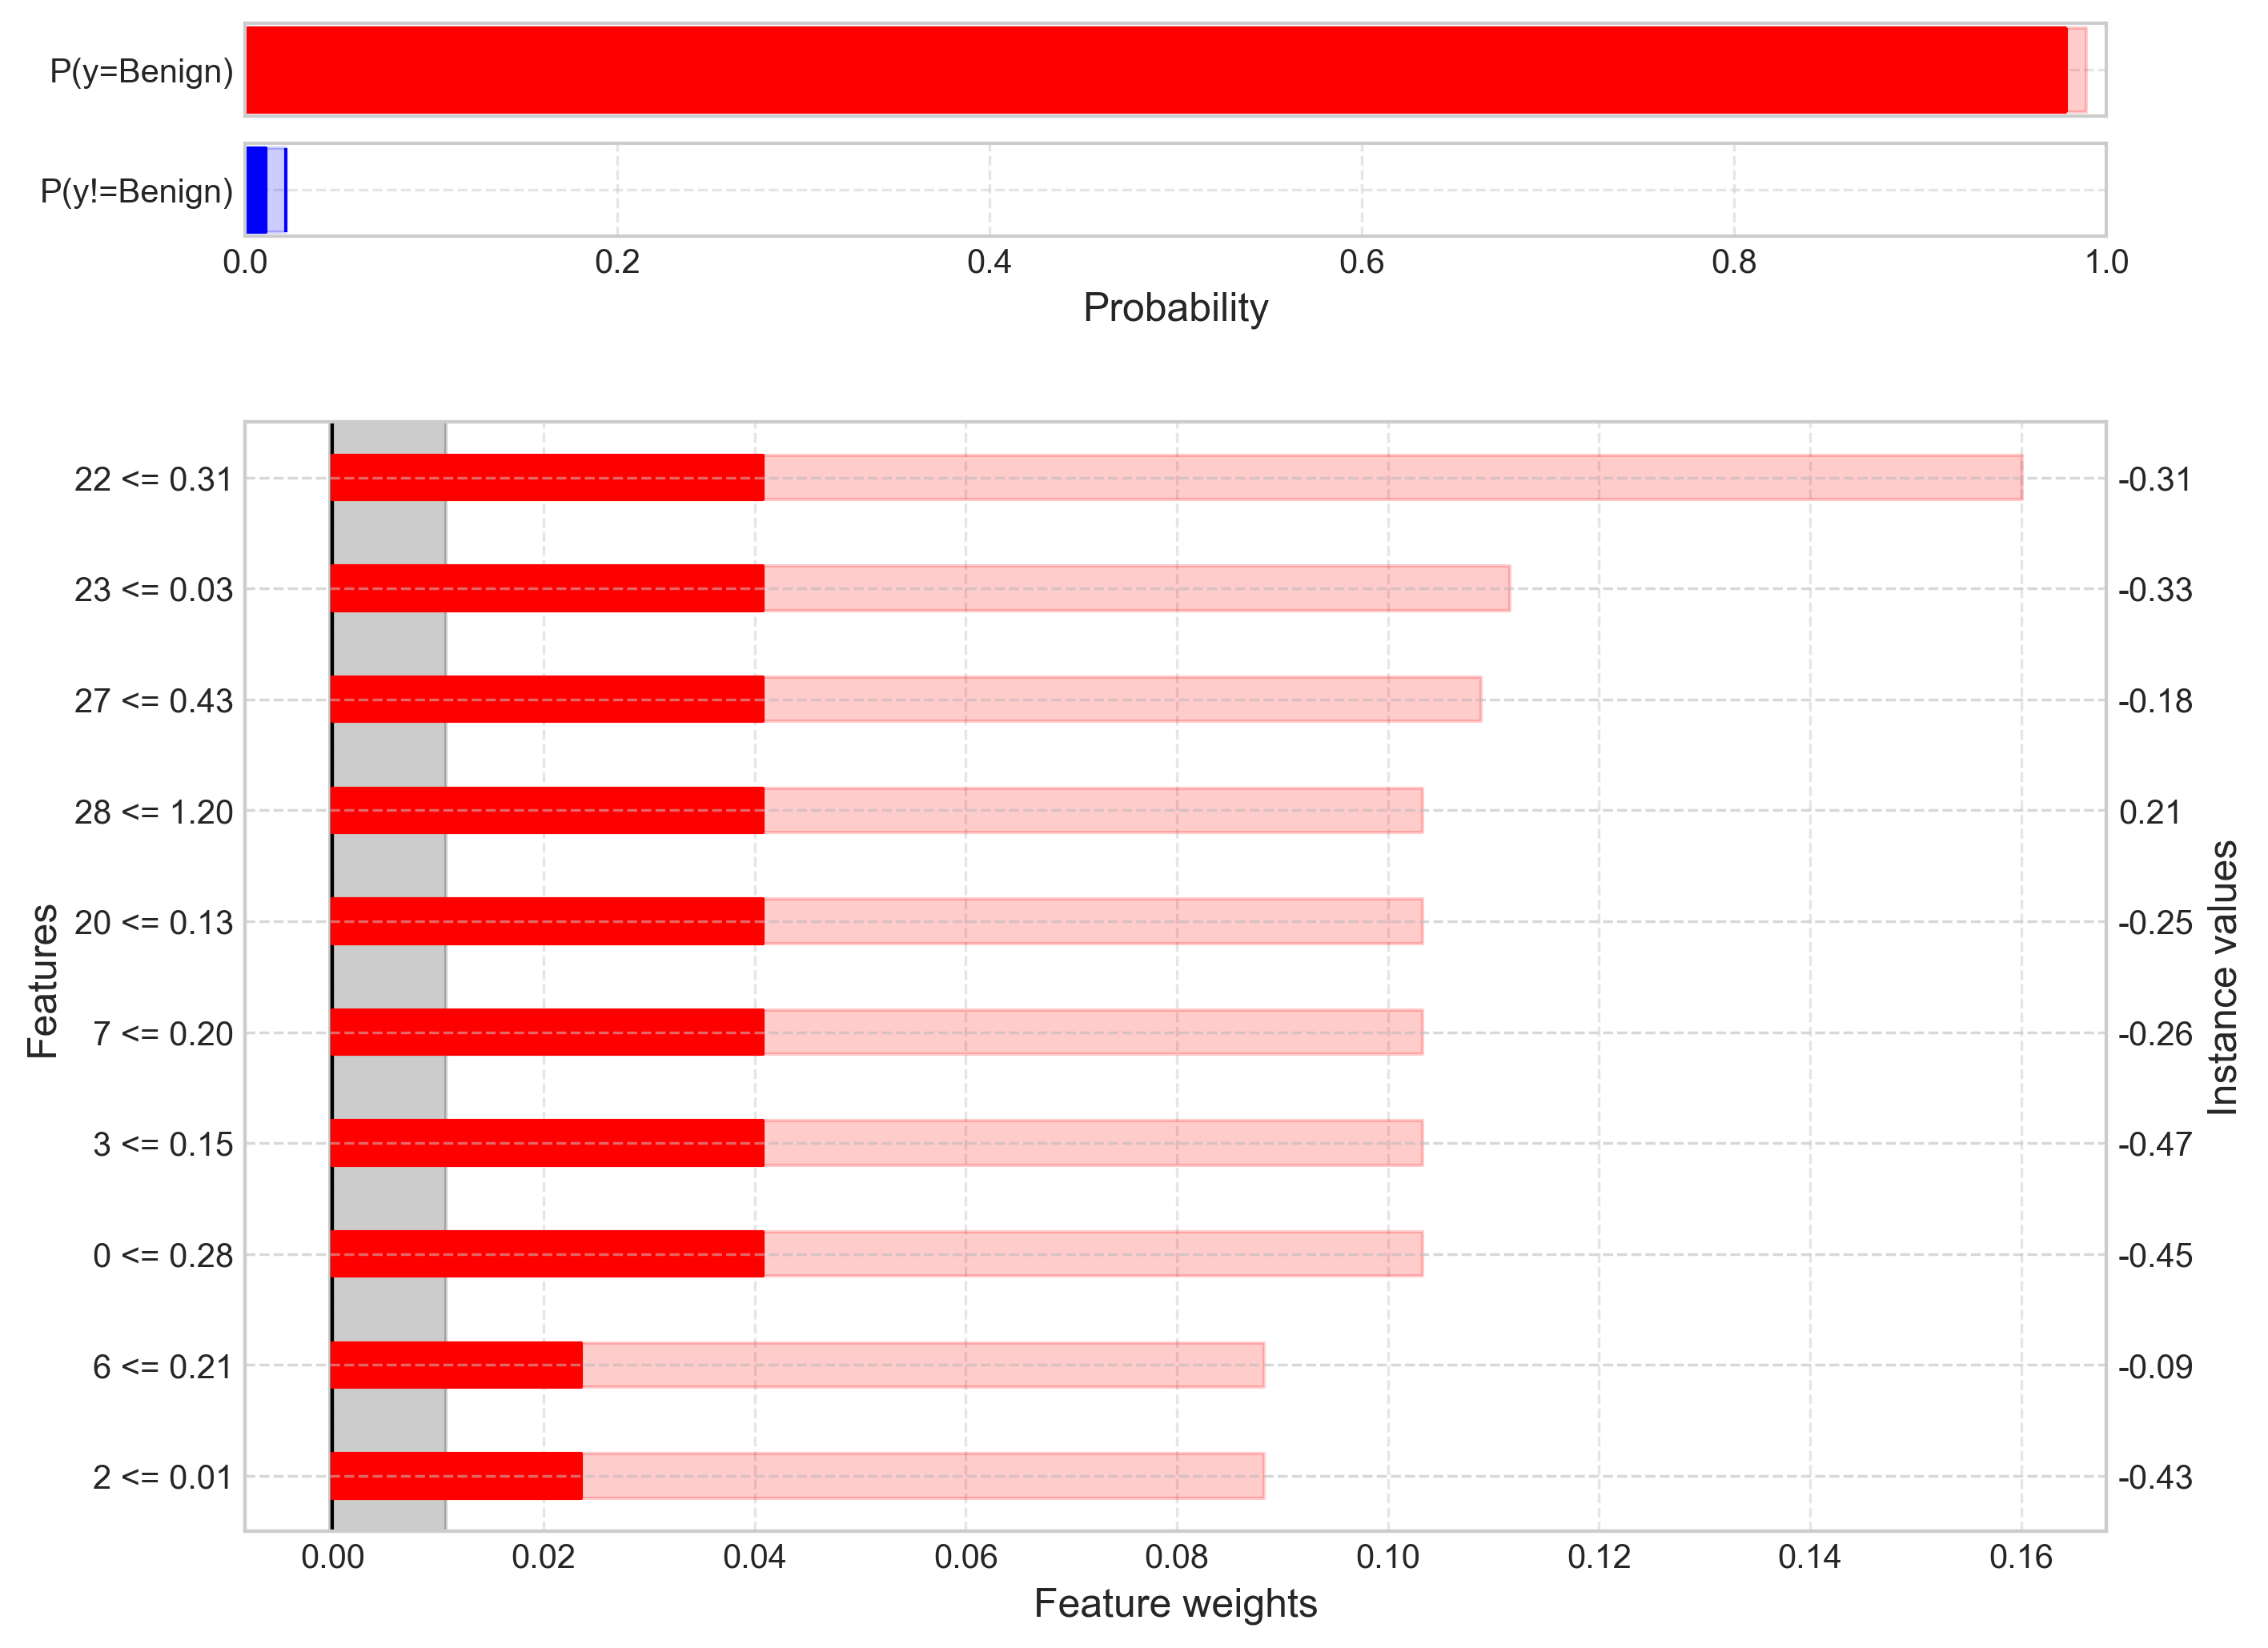

In [20]:
# Plot with legacy style
print("\n--- Using legacy style ---")
explanations_compare.plot(
    index=0,
    show=True,
    style_override="legacy",
    uncertainty=True,
)
print("✓ Legacy matplotlib-based visualization rendered")

## Summary: Choosing Your Wiring Method

| Method | Best For | Example |
|--------|----------|----------|
| **A** | Development, consistent defaults | `CalibratedExplainer(..., plot_style="my.plot")` |
| **B** | Experimentation, style comparison | `explanations.plot(style_override="alt.plot")` |
| **C** | CI/CD, ops deployment | `export CE_PLOT_STYLE="my.plot"` |
| **D** | Project-level config | `[tool.calibrated-explanations.plots]` in pyproject.toml |
| **E** | Plugin self-containment | `"plot_dependency": "my.plot"` in plugin_meta |

**Key takeaways:**
- Plugins are modular and composable
- Multiple wiring methods can coexist; priority order applies
- Fallback chains ensure graceful degradation
- No external class instantiation needed; just register and wire!

For more details, see:
- `docs/contributor/plugin-contract.md` – Basic plugin examples
- `docs/contributor/extending/plugin-advanced-contract.md` – Advanced wiring methods